In [1]:
from __future__ import print_function
import six

In [2]:
import yaml
import numpy
import pandas
import toyplot.pdf

print("yaml version:    ", yaml.__version__)
print("numpy version:   ", numpy.__version__)
print("pandas version:  ", pandas.__version__)
print("toyplot version: ", toyplot.__version__)

yaml version:     3.12
numpy version:    1.13.1
pandas version:   0.20.3
toyplot version:  0.15.1


Load the data, which has already been processed into a YAML file.

In [3]:
yaml_data = yaml.load(file('external-faces-log-haswell-2017-04-19.yaml', 'r'))
data = pandas.DataFrame(yaml_data)
#data.head(5)

In [4]:
print('Host:         ', data['hostname'][0])
print('VTK-m version:', data['vtkm-version'][0])

Host:          hansen02
VTK-m version: 1.0.0-1151-gf0d126a


The YAML data is hierarchical. The basic yaml reader to DataFrame just embeds dictionaries and lists in DataFrame columns. Fix that by expanding the data of these columns into new columns.

In [5]:
def expand_single_column(original_data, column_to_expand):
    expanded_data = pandas.DataFrame()
    for index in original_data.index:
        sub_table = pandas.DataFrame(original_data[column_to_expand][index])
        for column in original_data.columns:
            if column != column_to_expand:
                sub_table[column] = numpy.full(sub_table.index.shape,
                                               original_data[column][index],
                                               dtype=original_data[column].dtype)
        expanded_data = expanded_data.append(sub_table, ignore_index=True)
    return expanded_data

def expand_columns(original_data, columns_to_expand):
    if isinstance(columns_to_expand, six.string_types):
        return expand_single_column(original_data, columns_to_expand)
    else:
        expanded_data = original_data
        for column in columns_to_expand:
            expanded_data = expand_single_column(expanded_data, column)
        return expanded_data

In [6]:
flat_data = expand_columns(data, ['experiments', 'trials'])
#flat_data.columns

Rename the algorithms to match those in the paper.

In [7]:
flat_data['full-name'].replace('Sort Id3', 'SortByID', inplace=True)
flat_data['full-name'].replace('Sort XOR Indices', 'Sort+XOR', inplace=True)
flat_data['full-name'].replace('Sort FNV1A', 'Sort+FNV1a', inplace=True)
flat_data['full-name'].replace('Sort Morton', 'Sort+Morton', inplace=True)
flat_data['full-name'].replace('Hash Fight XOR Indices', 'Hash-Fight+XOR', inplace=True)
flat_data['full-name'].replace('Hash Fight FNV1A', 'Hash-Fight+FNV1a', inplace=True)
flat_data['full-name'].replace('Hash Fight Morton', 'Hash-Fight+Morton', inplace=True)

## Compare hash functions per grid

In this section we are going to pick a particular input grid and compare the (average) time that each has function and algorithm takes to complete. To do this, we first create a pivot table that aggregates the data based on these collections.

In [8]:
pivot_data = \
    flat_data.pivot_table(values='seconds-total', 
                          index='full-name',
                          columns=['size-x', 'topology-connections'],
                          aggfunc='mean')
print(pivot_data.columns.levels[0])
print(pivot_data.columns.levels[1])
print(pivot_data.index)

Int64Index([100, 128, 150, 175, 200, 225, 256, 275, 300, 325, 350, 384, 400,
            425, 450, 475, 512],
           dtype='int64', name=u'size-x')
Index([u'randomized', u'regular'], dtype='object', name=u'topology-connections')
Index([u'Hash-Fight+FNV1a', u'Hash-Fight+Morton', u'Hash-Fight+XOR',
       u'Sort+FNV1a', u'Sort+Morton', u'Sort+XOR', u'SortByID'],
      dtype='object', name=u'full-name')


The following function is a convenient way to make a table for a given grid size/topology.

In [9]:
ordered_names = ['SortByID',
                 'Sort+XOR',
                 'Sort+FNV1a',
                 'Sort+Morton',
                 'Hash-Fight+XOR',
                 'Hash-Fight+FNV1a',
                 'Hash-Fight+Morton']

def make_table(size, topology):
    time_data = pandas.DataFrame({'Algorithm':ordered_names,
                                  'Seconds':pivot_data[size][topology][ordered_names],
                                  'Seconds2':pivot_data[size][topology][ordered_names]})
    
    canvas = toyplot.Canvas(width='9in', height='3in')
    table = canvas.table(time_data,
                         label='{}<sup>3</sup> Grid, {} Topology'.format(size, topology))
    table.top.cell[0,1:3].merge().data = 'Time (seconds)'
    table.body.column[0].align = 'left'
    table.body.column[1].format = toyplot.format.FloatFormatter('{:.1f}s')

    table.body.column[0].width = '1.4in'
    table.body.column[1].width = '0.5in'

    axes = table.body.column[2].cartesian()
    axes.cell_bars(width=1.0)
    
    return canvas

There are a lot of mesh sizes that we computed, so let's just start with the smallest grids first.

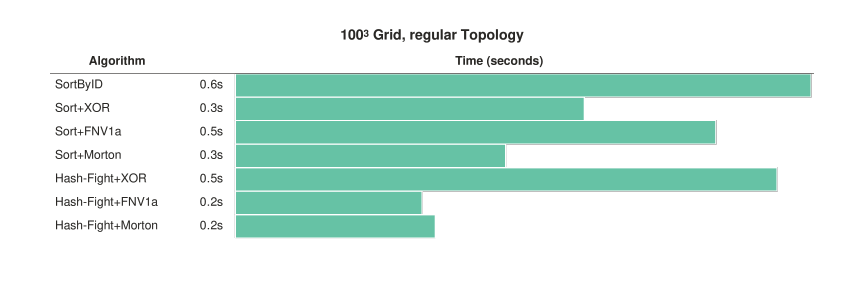

In [10]:
make_table(100, 'regular')

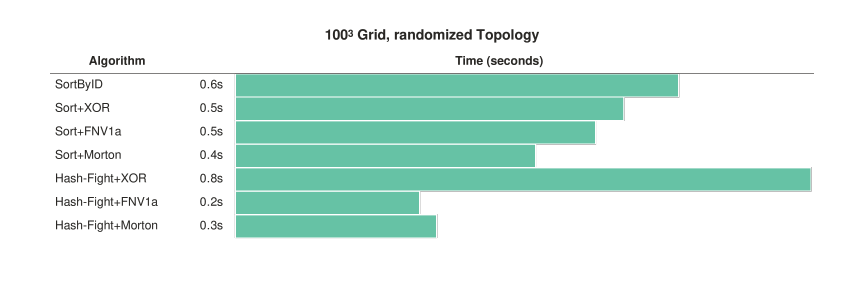

In [11]:
make_table(100, 'randomized')

From these measurements, it looks like the hash fight approach is out performing the sorting approach by a good margin. With the hash fight the FNV1A is beating out the XOR indices, which is what we would expect. But oddly, for the sorting approach it looks like XOR is beating FNV1A, which is very counterintuitive. For regular grids, FNV1A performs horribly. I wonder what is going on there. XOR is even beating Morton codes for the regular grid. This must be because it takes less time to compute.

Next we look at the largeset grids.

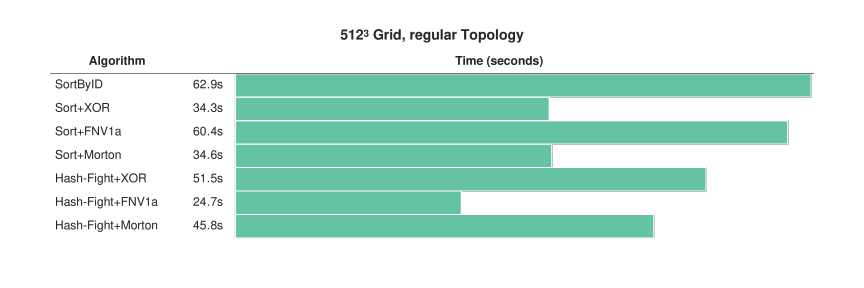

In [12]:
make_table(512, 'regular')

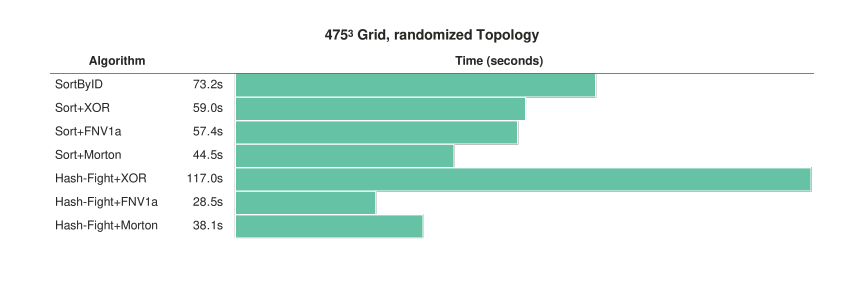

In [13]:
make_table(475, 'randomized')

The results for the largest grid are similar to that of the smallest one. The hash fight with FNV1A is the best performer, beating hash fight with morton encoding by a small margin. For the sorting approach, XOR is still working surprisingly well, especially for regular grids. The orientation in this case must generate very unique hashes.

Sorting based on Id3 is clearly the loser.

## Sorted hash behavior behavior

I'm curious about the behavior of the XOR hash compared to the others, particularly with respect to regular topology. Why is it so much faster? Let's take a look at the breakdown of the time for the Sort approach for XOR, FNV1A, and Morton on the largest grid.

In [14]:
pivot_data = \
    flat_data.pivot_table(values=['seconds-num-faces-per-cell',
                                  'seconds-face-input-count',
                                  'seconds-morton-codes',
                                  'seconds-face-hash',
                                  'seconds-keys-build-arrays',
                                  'seconds-face-count',
                                  'seconds-face-output-count',
                                  'seconds-points-per-face',
                                  'seconds-build-connectivity',],
                          columns=['size-x', 'topology-connections', 'full-name'],
                          aggfunc='mean')
pivot_data = pivot_data.swaplevel(0,1).swaplevel(1,2).swaplevel(2,3)
pivot_data[512]['regular']['Sort+XOR']

seconds-num-faces-per-cell     0.232274
seconds-face-input-count       1.571356
seconds-morton-codes                NaN
seconds-face-hash              2.166348
seconds-keys-build-arrays     20.146960
seconds-face-count             9.770078
seconds-face-output-count      0.087531
seconds-points-per-face        0.059922
seconds-build-connectivity     0.057239
dtype: float64

In [15]:
pivot_data[512]['regular']['Sort+FNV1a']

seconds-num-faces-per-cell     0.229693
seconds-face-input-count       1.561576
seconds-morton-codes                NaN
seconds-face-hash              2.197380
seconds-keys-build-arrays     44.901260
seconds-face-count            10.609600
seconds-face-output-count      0.553546
seconds-points-per-face        0.042574
seconds-build-connectivity     0.046513
dtype: float64

In [16]:
pivot_data[512]['regular']['Sort+Morton']

seconds-num-faces-per-cell     0.233946
seconds-face-input-count       1.566106
seconds-morton-codes           0.191265
seconds-face-hash              2.172946
seconds-keys-build-arrays     23.880600
seconds-face-count             5.962396
seconds-face-output-count      0.194770
seconds-points-per-face        0.077886
seconds-build-connectivity     0.075574
dtype: float64

So, it looks like all implementations are spending most of their time building the keys array, which involves sorting the array, identifying unique values in the array, compressing the array to unique instances, and computing the reverse lookup. Perhaps this is about data movement. In indices from a regular grid, the XOR hashes are probably in about the correct order, and a radix sort does not have to move data around much (I guess). (Either that or a "slow path" is being used and the merge sort is working better on a mostly presorted array.) The fact that the XOR hashes produce the longest seconds-face-count indicates that there is the most hash clashes there.

This might also indicate why the hash fight is running faster. The sort is (probably) taking the most time in the algorithm. The hash fight skips the sorting part of the algorithm.

## Trend Plots

Let us create trend plots of the algorithm behavior as we increase the size of the input.

In [17]:
pivot_data = \
    flat_data.pivot_table(index='num-input-cells',
                          columns=['topology-connections','full-name'],
                          values='seconds-total',
                          aggfunc='mean')

pivot_data

topology-connections       randomized                                   \
full-name            Hash-Fight+FNV1a Hash-Fight+Morton Hash-Fight+XOR   
num-input-cells                                                          
4851495                      0.249514          0.272600       0.779491   
10241915                     0.521959          0.988345       1.973703   
16539745                     0.846578          0.927853       2.959441   
26340120                     1.341141          1.648701       4.297551   
39402995                     2.015868          2.235304       8.569978   
56197120                     2.884589          6.274936      10.046422   
82906875                     4.265101          9.405385      19.917020   
102854120                    5.293432          6.447271      18.385440   
133654495                    6.907450          7.994440      28.162460   
170061120                    8.800732         10.743180      39.321660   
212542745                   11.139310         13.526490      39.417880   
280909435                   14.667420         17.303420      63.153220   
317605995                   16.950820         19.445620      79.003420   
381125120                   20.393760         23.454760      73.152820   
452594245                   24.366100         28.909440      88.373500   
532482120                   28.520560         38.124920     116.961800   
667164155                         NaN               NaN            NaN   

topology-connections                                               \
full-name            Sort+FNV1a Sort+Morton   Sort+XOR   SortByID   
num-input-cells                                                     
4851495                0.487709    0.406444   0.526118   0.600320   
10241915               0.928694    0.798100   1.118514   1.331975   
16539745               1.573882    1.093413   1.649307   1.970332   
26340120               2.425953    1.831839   2.574784   3.103062   
39402995               3.601495    2.720467   3.856227   4.455412   
56197120               5.422683    4.020948   5.294670   6.840981   
82906875               8.000769    5.959867   8.688813  10.377420   
102854120              9.932371    7.600432  10.125737  12.935370   
133654495             13.062190   10.007725  14.171570  20.129210   
170061120             16.397920   13.642580  18.211970  21.712420   
212542745             21.242930   16.103520  22.804820  27.847160   
280909435             28.546280   22.094960  30.754240  37.476800   
317605995             33.296380   24.525040  34.499080  46.138000   
381125120             39.730020   30.545100  41.204180  51.043740   
452594245             45.972600   35.842060  47.833260  68.303740   
532482120             57.365660   44.454880  58.956580  73.201320   
667164155                   NaN         NaN        NaN        NaN   

topology-connections          regular                                   \
full-name            Hash-Fight+FNV1a Hash-Fight+Morton Hash-Fight+XOR   
num-input-cells                                                          
4851495                      0.182691          0.195701       0.530257   
10241915                     0.371210          0.611866       0.860975   
16539745                     0.588668          0.628567       1.611404   
26340120                     0.938337          1.081411       2.282283   
39402995                     1.365785          1.431872       3.727137   
56197120                     1.975366          3.901382       4.788466   
82906875                     2.841192          5.212892       6.411882   
102854120                    3.570131          3.825440       9.019762   
133654495                    4.612678          4.832555      12.678720   
170061120                    5.919789          6.447109      15.156420   
212542745                    7.436382          7.980670      20.206910   
280909435                    9.815250         10.391260      21.877780   
317605995                   

In [18]:
grouped = flat_data.groupby(['topology-connections','full-name'])
#flat_data.loc[grouped.groups[('regular', 'Sort+Morton')]]

In [19]:
topology_connections = 'regular'
algorithms = ordered_names

canvas = toyplot.Canvas('8in', '4in')
axes = canvas.cartesian(bounds=(45,-15,6,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 775
axes.x.ticks.locator = toyplot.locator.Explicit([0,200,400,600])

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Sort+Morton':
        label = '&#160;<br/>Sort+Morton'
    elif alg == 'Sort+XOR':
        label = 'Sort+XOR<br/>&#160;'
    else:
        label = alg
    axes.text(x[-1], y[-1], label,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt'})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

<path d="M 49.432075432258067 331.12759093485698 L 54.356484929032256 329.5474874873014 L 60.109857367741938 326.94223036599988 L 69.062974141935484 322.52681600163447 L 80.996542529032254 316.9669833386917 L 96.338788335483869 309.31671710302902 L 120.73944193548387 297.09222944618 L 138.96221543225806 288.56442254943875 L 167.09984833548384 273.46308848896956 L 200.35906188387096 257.25347012715179 L 239.16808188387097 235.96158746480779 L 301.6243612645161 205.37071978396847 L 335.14844446451616 184.86372036325307 L 393.17623865806456 153.80122932363341 L 458.46674252903233 116.31293375351748 L 531.44818188387092 77.435159288971036 L 654.48673772903237 13.062598733866178" style="stroke:rgb(10.6%,62%,46.7%);stroke-opacity:1.0;stroke-width:2.0"> SortByID <path d="M 49.432075432258067 332.25853916044446 L 54.356484929032256 331.28339999670533 L 60.109857367741938 329.43208354579173 L 69.062974141935484 326.88843471131349 L 80.996542529032254 323.21851156619903 L 96.338788335483869 318.79214024401722 L 120.73944193548387 313.08706288246282 L 138.96221543225806 306.44431670555849 L 167.09984833548384 297.35585415716099 L 200.35906188387096 287.30352092918906 L 239.16808188387097 274.95041011048107 L 301.6243612645161 261.6993743043335 L 335.14844446451616 245.36754175970532 L 393.17623865806456 227.37039438864645 L 458.46674252903233 205.79992253361314 L 531.44818188387092 184.35355135482536 L 654.48673772903237 158.89629118773314" style="stroke:rgb(85.1%,37.3%,0.8%);stroke-opacity:1.0;stroke-width:2.0"> Sort+XOR   <path d="M 49.432075432258067 331.60168458031114 L 54.356484929032256 329.63467305606326 L 60.109857367741938 327.07308162956463 L 69.062974141935484 322.28275983606977 L 80.996542529032254 315.76804028120841 L 96.338788335483869 307.3104670251937 L 120.73944193548387 302.06724404560424 L 138.96221543225806 287.0133068580347 L 167.09984833548384 268.2469851271677 L 200.35906188387096 254.72082719734669 L 239.16808188387097 237.79434133018285 L 301.6243612645161 198.63257312418699 L 335.14844446451616 175.86198552656211 L 393.17623865806456 154.83288630109959 L 458.46674252903233 114.68738824815152 L 531.44818188387092 78.177214030991507 L 654.48673772903237 25.90849732824416" style="stroke:rgb(45.9%,43.9%,70.2%);stroke-opacity:1.0;stroke-width:2.0"> Sort+FNV1a <path d="M 49.432075432258067 332.65159108737822 L 54.356484929032256 331.36972134752864 L 60.109857367741938 329.91062013821715 L 69.062974141935484 327.81628356353895 L 80.996542529032254 324.55853883947486 L 96.338788335483869 320.54057805010416 L 120.73944193548387 312.95569665717659 L 138.96221543225806 309.35191295217135 L 167.09984833548384 301.94384698042364 L 200.35906188387096 293.69437944345736 L 239.16808188387097 282.62741866524436 L 301.6243612645161 266.11427880560836 L 335.14844446451616 256.40974868487098 L 393.17623865806456 241.46270429424013 L 458.46674252903233 222.60429619058468 L 531.44818188387092 203.66227054007521 L 654.48673772903237 157.48845722204194" style="stroke:rgb(90.6%,16.1%,54.1%);stroke-opacity:1.0;stroke-width:2.0">   Sort+Morton <path d="M 49.432075432258067 331.29641476195525 L 54.356484929032256 329.61020727566211 L 60.109857367741938 325.78404576397702 L 69.062974141935484 322.36348136056932 L 80.996542529032254 314.99670410189634 L 96.338788335483869 309.58537926134483 L 120.73944193548387 301.30818027088219 L 138.96221543225806 288.01156270443738 L 167.09984833548384 269.3558863628557 L 200.35906188387096 256.72300856771932 L 239.16808188387097 230.97242416462012 L 301.6243612645161 222.45327474315684 L 335.14844446451616 185.77892461083229 L 393.17623865806456 167.1601521597463 L 458.46674252903233 114.74877576425651 L 531.44818188387092 94.842089146382236 L 654.48673772903237 71.510040313417917" style="stroke:rgb(40%,65.1%,11.8%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+XOR <path d="M 49.432075432258067 333.06852449161136 L 54.356484929032256 332.10733773134569 L 60.109857367741938 330.99859863212049 L 69.062

In [20]:
toyplot.pdf.render(canvas, 'sizextime-haswell-regular.pdf')

In [21]:
topology_connections = 'regular'
algorithms = ordered_names

canvas = toyplot.Canvas('4.5in', '2.7in')
axes = canvas.cartesian(bounds=(45,-15,6,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 930
axes.x.ticks.locator = toyplot.locator.Explicit([0,200,400,600])

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Sort+Morton':
        label = '&#160;<br/>Sort+Morton'
    elif alg == 'Sort+XOR':
        label = 'Sort+XOR<br/>&#160;'
    elif alg == 'Sort+FNV1a':
        label = '&#160;<br/>Sort+FNV1a'
    else:
        label = alg
    axes.text(x[-1], y[-1], label,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt'})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

<path d="M 46.940598000000001 207.44373342557878 L 49.096766000000002 206.47761655081138 L 51.615898000000001 204.88469371282179 L 55.536048000000001 202.18499304885384 L 60.761198 198.78556488808266 L 67.478847999999999 194.10799056965999 L 78.162749999999988 186.63361676904697 L 86.141648000000004 181.4194909721283 L 98.461798000000002 172.1861374914499 L 113.02444799999999 162.27514979180373 L 130.017098 149.25673180943633 L 157.36377399999998 130.55266941025829 L 172.04239799999999 118.01414971912787 L 197.45004799999998 99.021724373740739 L 226.03769800000001 76.100392854221042 L 257.99284799999998 52.329497333610639 L 311.86566200000004 12.970417951508065" style="stroke:rgb(10.6%,62%,46.7%);stroke-opacity:1.0;stroke-width:2.0"> SortByID <path d="M 46.940598000000001 208.13522496489458 L 49.096766000000002 207.53899919069448 L 51.615898000000001 206.40705554072079 L 55.536048000000001 204.85180163233045 L 60.761198 202.60791393935716 L 67.478847999999999 199.90151390272541 L 78.162749999999988 196.4132793068336 L 86.141648000000004 192.35172929488212 L 98.461798000000002 186.79480386238467 L 113.02444799999999 180.64854250376735 L 130.017098 173.09552511348926 L 157.36377399999998 164.99349273056447 L 172.04239799999999 155.00778005988448 L 197.45004799999998 144.00385003254721 L 226.03769800000001 130.81509527849479 L 257.99284799999998 117.70221894726106 L 311.86566200000004 102.13697942397536" style="stroke:rgb(85.1%,37.3%,0.8%);stroke-opacity:1.0;stroke-width:2.0"> Sort+XOR   <path d="M 46.940598000000001 207.73360677013852 L 49.096766000000002 206.53092410440689 L 51.615898000000001 204.96469962256782 L 55.536048000000001 202.03577067970588 L 60.761198 198.05249951726043 L 67.478847999999999 192.8813164185475 L 78.162749999999988 189.67547175908169 L 86.141648000000004 180.47109797513792 L 98.461798000000002 168.99687448075036 L 113.02444799999999 160.72662518347491 L 130.017098 150.377325805591 L 157.36377399999998 126.43278902980387 L 172.04239799999999 112.51025189436029 L 197.45004799999998 99.652506628183318 L 226.03769800000001 75.106491508163032 L 257.99284799999998 52.783209151894582 L 311.86566200000004 20.824738770046167" style="stroke:rgb(45.9%,43.9%,70.2%);stroke-opacity:1.0;stroke-width:2.0">   Sort+FNV1a <path d="M 46.940598000000001 208.37554726775264 L 49.096766000000002 207.59177833867506 L 51.615898000000001 206.69964542010567 L 55.536048000000001 205.41911286423448 L 60.761198 203.42724191649887 L 67.478847999999999 200.97055483897236 L 78.162749999999988 196.33295853592469 L 86.141648000000004 194.12951023904031 L 98.461798000000002 189.60002354260433 L 113.02444799999999 184.55608176294513 L 130.017098 177.78945039032132 L 157.36377399999998 167.69288165080678 L 172.04239799999999 161.75927627462889 L 197.45004799999998 152.62025956276381 L 226.03769800000001 141.08973203408996 L 257.99284799999998 129.50807853441256 L 311.86566200000004 101.27619264876193" style="stroke:rgb(90.6%,16.1%,54.1%);stroke-opacity:1.0;stroke-width:2.0">   Sort+Morton <path d="M 46.940598000000001 207.54695676103495 L 49.096766000000002 206.51596508173247 L 51.615898000000001 204.17654913542654 L 55.536048000000001 202.08512594634783 L 60.761198 197.58088425681348 L 67.478847999999999 194.27225769100698 L 78.162749999999988 189.21136017011065 L 86.141648000000004 181.08145789811439 L 98.461798000000002 169.67488590962614 L 113.02444799999999 161.95081161965683 L 130.017098 146.20622593101535 L 157.36377399999998 140.99739354255794 L 172.04239799999999 118.5737297066362 L 197.45004799999998 107.18972172900911 L 226.03769800000001 75.144025452729011 L 257.99284799999998 62.97255282415702 L 311.86566200000004 48.706723498048113" style="stroke:rgb(40%,65.1%,11.8%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+XOR <path d="M 46.940598000000001 208.63047133497554 L 49.096766000000002 208.04277642782739 L 51.615898000000001 207.36486413345639 L 55.536048000000001 206.27479265373461 L 60.761198 204.94225095688512 L 67.478847

In [22]:
toyplot.pdf.render(canvas, 'sizextime-haswell-regular-small.pdf')

In [23]:
topology_connections = 'randomized'
algorithms = ordered_names

canvas = toyplot.Canvas('8in', '4in')
axes = canvas.cartesian(bounds=(45,-15,15,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

# Help toyplot to size the area large enough for the labels
#axes.x.domain.max = 775
axes.x.ticks.locator = toyplot.locator.Explicit([0,100,200,300,400,500])

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Sort+XOR':
        vert_align = 'first-baseline'
    elif alg == 'Sort+FNV1a':
        vert_align = 'top'
    else:
        vert_align = 'middle'
    axes.text(x[-2], y[-2], alg,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt',
                     '-toyplot-vertical-align':vert_align})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

<path d="M 50.148445752455032 332.40414853583331 L 55.868803075908659 330.45916645833336 L 62.552111234153458 328.76220076666664 L 72.9523484891061 325.75102685000002 L 86.814777144314647 322.15602976666662 L 104.63683849291932 315.81439217499997 L 132.98144663512386 306.41335849999996 L 154.14962444287789 299.61347475000002 L 186.83523163051225 280.48985008333335 L 225.47023668410361 276.28115016666663 L 270.55208089679218 259.97296633333332 L 343.10336555026697 234.37417333333329 L 382.04605197202176 211.34981666666667 L 449.4530614208432 198.30872450000004 L 525.29667520132284 152.4258911666667 L 610.0743346066007 139.40649099999996" style="stroke:rgb(10.6%,62%,46.7%);stroke-opacity:1.0;stroke-width:2.0"> SortByID <path d="M 50.148445752455032 332.60140431249999 L 55.868803075908659 331.02661694999995 L 62.552111234153458 329.61559222500006 L 72.9523484891061 327.15536586666667 L 86.814777144314647 323.74886322500004 L 104.63683849291932 319.92500225000003 L 132.98144663512386 310.902238775 L 154.14962444287789 307.08241580833334 L 186.83523163051225 296.32724308333331 L 225.47023668410361 285.58651308333333 L 270.55208089679218 273.37718683333333 L 343.10336555026697 252.2449786666667 L 382.04605197202176 242.28994566666665 L 449.4530614208432 224.46555483333336 L 525.29667520132284 206.84325050000001 L 610.0743346066007 177.27375816666668" style="stroke:rgb(85.1%,37.3%,0.8%);stroke-opacity:1.0;stroke-width:2.0"> Sort+XOR <path d="M 50.148445752455032 332.70350690833334 L 55.868803075908659 331.53122178333336 L 62.552111234153458 329.81609701666667 L 72.9523484891061 327.55100827500002 L 86.814777144314647 324.42602579166663 L 104.63683849291932 319.58470102499996 L 132.98144663512386 312.73128907500006 L 154.14962444287789 307.59644709166668 L 186.83523163051225 299.27634491666669 L 225.47023668410361 290.40886266666666 L 270.55208089679218 277.52921108333334 L 343.10336555026697 258.11447233333331 L 382.04605197202176 245.48712316666666 L 449.4530614208432 228.38436349999998 L 525.29667520132284 211.78950499999999 L 610.0743346066007 181.50295383333332" style="stroke:rgb(45.9%,43.9%,70.2%);stroke-opacity:1.0;stroke-width:2.0"> Sort+FNV1a <path d="M 50.148445752455032 332.91953610083334 L 55.868803075908659 331.87838416666665 L 62.552111234153458 331.09334377499999 L 72.9523484891061 329.13036132499997 L 86.814777144314647 326.7680918916667 L 104.63683849291932 323.31097989999995 L 132.98144663512386 318.15668689166665 L 154.14962444287789 313.7955182666667 L 186.83523163051225 307.39613104166671 L 225.47023668410361 297.73347483333333 L 270.55208089679218 291.19147600000002 L 343.10336555026697 275.26423133333333 L 382.04605197202176 268.80426866666664 L 449.4530614208432 252.80094249999999 L 525.29667520132284 238.71985716666666 L 610.0743346066007 215.82411066666663" style="stroke:rgb(90.6%,16.1%,54.1%);stroke-opacity:1.0;stroke-width:2.0"> Sort+Morton <path d="M 50.148445752455032 331.92785415499998 L 55.868803075908659 328.75323952500003 L 62.552111234153458 326.13281934166667 L 72.9523484891061 322.57567692500004 L 86.814777144314647 311.21814181666667 L 104.63683849291932 307.29326151666669 L 132.98144663512386 281.05392183333333 L 154.14962444287789 285.12537199999997 L 186.83523163051225 259.13479383333333 L 225.47023668410361 229.4699205 L 270.55208089679218 229.21413566666666 L 343.10336555026697 166.11769016666668 L 382.04605197202176 123.98257516666668 L 449.4530614208432 139.53542016666671 L 525.29667520132284 99.073779166666668 L 610.0743346066007 23.076548333333335" style="stroke:rgb(40%,65.1%,11.8%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+XOR <path d="M 50.148445752455032 333.33670835083331 L 55.868803075908659 332.61245952333331 L 62.552111234153458 331.74951321750001 L 72.9523484891061 330.43480017499996 L 86.814777144314647 328.64115090000001 L 104.63683849291932 326.33180090833332 L 132.98144663512386 322.66193984166671 L 154.14962444287789 319.92829326666669 L 186.83523163051225 315.63769541

In [24]:
toyplot.pdf.render(canvas, 'sizextime-haswell-randomized.pdf')

In [25]:
topology_connections = 'randomized'
algorithms = ordered_names

canvas = toyplot.Canvas('4.5in', '2.7in')
axes = canvas.cartesian(bounds=(45,-15,15,-50),
                        xlabel='Number of Input Cells (Millions)',
                        ylabel='Time (seconds)')

# Help toyplot to size the area large enough for the labels
axes.x.domain.max = 725
axes.x.ticks.locator = toyplot.locator.Explicit([0,200,400])

# This is a hack to change the default colors used by the plots.
# Hopefully future versions of toyplot will make setting this easier
palette = toyplot.color.brewer.palette('Dark2')
import itertools
axes._palette = toyplot.color.brewer.palette('Dark2')
axes._plot_colors = itertools.cycle(palette)
axes._scatterplot_colors = itertools.cycle(palette)
axes._text_colors = itertools.cycle(palette)

for alg in algorithms:
    series = pivot_data[topology_connections][alg]
    x = series.index / 1000000.0
    y = numpy.array(series)
    axes.plot(x, y)

    # Correct label placement for coincident labels
    if alg == 'Sort+XOR':
        vert_align = 'first-baseline'
    elif alg == 'Sort+FNV1A':
        vert_align = 'top'
    else:
        vert_align = 'middle'
    axes.text(x[-2], y[-2], alg,
              style={'text-anchor':'start',
                     '-toyplot-anchor-shift':'5pt',
                     '-toyplot-vertical-align':vert_align})
    
    dataGroup = flat_data.loc[grouped.groups[(topology_connections, alg)]]
    x = dataGroup['num-input-cells']/ 1000000.0
    y = dataGroup['seconds-total']
    axes.scatterplot(x, y)

<path d="M 47.489318813793105 208.23881822253722 L 50.255161903448283 207.06735498027311 L 53.486600193103449 206.04527207567071 L 58.515206400000004 204.23164119431394 L 65.217812606896558 202.06637345848733 L 73.83493605517242 198.24680338617753 L 87.539803448275862 192.58455820821408 L 97.774803641379322 188.48898634822399 L 113.57858226206895 176.97082193169069 L 132.25894708965518 174.43592080991155 L 154.05641536551724 164.61349718460386 L 189.13559975172416 149.19533709318873 L 207.96473122758621 135.32776071611082 L 240.55661329655175 127.4731073036407 L 277.22766777931037 99.83786411928233 L 318.21841191724138 91.99627580440108" style="stroke:rgb(10.6%,62%,46.7%);stroke-opacity:1.0;stroke-width:2.0"> SortByID <path d="M 47.489318813793105 208.35762543128351 L 50.255161903448283 207.40913056807014 L 53.486600193103449 206.55926998663588 L 58.515206400000004 205.07747497177314 L 65.217812606896558 203.0257374902034 L 73.83493605517242 200.72262496923943 L 87.539803448275862 195.2882120371718 L 97.774803641379322 192.98753160974184 L 113.57858226206895 186.5096881081021 L 132.25894708965518 180.04054346371728 L 154.05641536551724 172.68686289249595 L 189.13559975172416 159.95892807936721 L 207.96473122758621 153.9630089550038 L 240.55661329655175 143.2273734349898 L 277.22766777931037 132.61345466971943 L 318.21841191724138 114.80374127357592" style="stroke:rgb(85.1%,37.3%,0.8%);stroke-opacity:1.0;stroke-width:2.0"> Sort+XOR <path d="M 47.489318813793105 208.41912185294319 L 50.255161903448283 207.71305419850205 L 53.486600193103449 206.68003407801365 L 58.515206400000004 205.31577050354437 L 65.217812606896558 203.4335926910631 L 73.83493605517242 200.51766144746892 L 87.539803448275862 196.38984953784032 L 97.774803641379322 193.29713279361133 L 113.57858226206895 188.28593295652985 L 132.25894708965518 182.94504594915097 L 154.05641536551724 175.18762824459429 L 189.13559975172416 163.49412573529628 L 207.96473122758621 155.88866984595558 L 240.55661329655175 145.58767297685847 L 277.22766777931037 135.59258512067009 L 318.21841191724138 117.35098699123867" style="stroke:rgb(45.9%,43.9%,70.2%);stroke-opacity:1.0;stroke-width:2.0"> Sort+FNV1a <path d="M 47.489318813793105 208.54923629522898 L 50.255161903448283 207.92215019783103 L 53.486600193103449 207.44932015319009 L 58.515206400000004 206.26701528159953 L 65.217812606896558 204.84421974970903 L 73.83493605517242 202.76200024266166 L 87.539803448275862 199.65756814070494 L 97.774803641379322 197.03083507380188 L 113.57858226206895 193.17648238139151 L 132.25894708965518 187.35666187937056 L 154.05641536551724 183.41641417588764 L 189.13559975172416 173.82343031583594 L 207.96473122758621 169.9325930181856 L 240.55661329655175 160.29378524967871 L 277.22766777931037 151.81274366579581 L 318.21841191724138 138.02262922760892" style="stroke:rgb(90.6%,16.1%,54.1%);stroke-opacity:1.0;stroke-width:2.0"> Sort+Morton <path d="M 47.489318813793105 207.95194598546223 L 50.255161903448283 206.03987471734081 L 53.486600193103449 204.46159491745303 L 58.515206400000004 202.31912705781096 L 65.217812606896558 195.47848052638463 L 73.83493605517242 193.11452403808295 L 87.539803448275862 177.31056250244902 L 97.774803641379322 179.76279806191019 L 113.57858226206895 164.1086656564446 L 132.25894708965518 146.24150425766757 L 154.05641536551724 146.08744498193184 L 189.13559975172416 108.08443843712135 L 207.96473122758621 82.706447039629055 L 240.55661329655175 92.073929877080218 L 277.22766777931037 67.703872331813699 L 318.21841191724138 21.930719218986791" style="stroke:rgb(40%,65.1%,11.8%);stroke-opacity:1.0;stroke-width:2.0"> Hash-Fight+XOR <path d="M 47.489318813793105 208.80049925658014 L 50.255161903448283 208.36428398782061 L 53.486600193103449 207.84453118956822 L 58.515206400000004 207.05267916109423 L 65.217812606896558 205.97236370755698 L 73.83493605517242 204.58144156999273 L 87.539803448275862 202.37108323633541 L 97.774803641379322 200.72460714948639 L 113.578582

In [26]:
toyplot.pdf.render(canvas, 'sizextime-haswell-randomized-small.pdf')

## Compare regular to randomized

For some "representative size," which is large but following the trend of sizes, compare the regular vs randomized times.

In [27]:
representative_mesh_size = 450
# The 450^3 mesh has 452,594,245 tetrahedra

In [28]:
ordered_connections = ['regular', 'random']

# Average all time values for each algorithm on regular/random representative mesh
pivot_data = \
    flat_data.pivot_table(columns='size-x',
                          index=['full-name','topology-connections'],
                          values='seconds-total',
                          aggfunc='mean')

pivot_data.reset_index(inplace=True)

# Changed randomized to random to fit better.
pivot_data['topology-connections'][pivot_data['topology-connections'] == 'randomized'] = 'random'

# Sort the rows in the order we want to show them.
pivot_data['full-name'] = pandas.Categorical(pivot_data['full-name'], ordered_names)
pivot_data['topology-connections'] = pandas.Categorical(pivot_data['topology-connections'], ordered_connections)
pivot_data.sort_values(['full-name', 'topology-connections'], inplace=True)

# Changed randomized to random to fit better.
pivot_data['topology-connections'][pivot_data['topology-connections'] == 'randomized'] = 'random'

# Create a table with the values we want
table_data = pandas.DataFrame({'Algorithm':pivot_data['full-name'],
                               'Mesh':pivot_data['topology-connections'],
                               'Seconds':pivot_data[representative_mesh_size],
                               'Bars':pivot_data[representative_mesh_size]})
table_data = table_data[['Algorithm', 'Mesh', 'Seconds', 'Bars']]

table_data

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,Algorithm,Mesh,Seconds,Bars
13,SortByID,regular,42.69520,42.69520
12,SortByID,random,68.30374,68.30374
11,Sort+XOR,regular,25.14402,25.14402
10,Sort+XOR,random,47.83326,47.83326
7,Sort+FNV1a,regular,43.01402,43.01402
6,Sort+FNV1a,random,45.97260,45.97260
9,Sort+Morton,regular,21.84816,21.84816
8,Sort+Morton,random,35.84206,35.84206
5,Hash-Fight+XOR,regular,43.00198,43.00198
4,Hash-Fight+XOR,random,88.37350,88.37350


In [31]:
canvas = toyplot.Canvas(width='4.5in', height='3in')
table = canvas.table(table_data,
                     bounds=(0,-1,1,-1))

table.top.cell[0,2:4].merge().data = 'Time (seconds)'
table.cells.column[0].align = 'left'
table.cells.column[1].align = 'left'
table.body.column[2].format = toyplot.format.FloatFormatter('{:.1f}s')

axes = table.body.column[3].cartesian()
axes.cell_bars(width=1.0)

# I hate gridlines, but they are useful for sizing columns
#table.cells.grid.vlines[...] = 'single'

table.cells.column[0].width = '1.15in'
table.cells.column[1].width = '0.6in'
table.cells.column[2].width = '0.4in'

table.body.gaps.rows[range(1,12,2)] = '0.075in'

Algorithm Mesh SortByID regular 42 . 7s SortByID random 68 . 3s Sort+XOR regular 25 . 1s Sort+XOR random 47 . 8s Sort+FNV1a regular 43 . 0s Sort+FNV1a random 46 . 0s Sort+Morton regular 21 . 8s Sort+Morton random 35 . 8s Hash-Fight+XOR regular 43 . 0s Hash-Fight+XOR random 88 . 4s Hash-Fight+FNV1a regular 16 . 3s Hash-Fight+FNV1a random 24 . 4s Hash-Fight+Morton regular 16 . 6s Hash-Fight+Morton random 28 . 9s Time (seconds)

In [32]:
toyplot.pdf.render(canvas, 'reg-vs-rand-haswell.pdf')